Setting

In [1]:
import os
import sys

import mlflow
import seaborn as sns

FIGURE_DIR = os.getcwd()
MIL_DIR = os.path.dirname(FIGURE_DIR)
NB_DIR = os.path.dirname(MIL_DIR)
ROOT_DIR = os.path.dirname(NB_DIR)
EXP_DIR = os.path.join(ROOT_DIR, "experiments")
sys.path.append(ROOT_DIR)

from mlflow_settings import TRACKING_URI
from utils.serialization_ops import load_pickle
from experiments.MIL.exps.run_train_baseline import select_sample_dataset
from core.datasets import ExSCNVDataset
from core.data_model import PatientDataSet

In [2]:
from sklearn.model_selection import StratifiedKFold

dataset = load_pickle("/data2/heon_dev/repository/3ASC-Confirmed-variant-Resys/dataset_positive_negative.pickle")
with open(os.path.join(EXP_DIR, "external_test_snv_sample_ids.txt")) as fh:
    external_snv_sample_ids = [line.strip() for line in fh.readlines()]
with open(os.path.join(EXP_DIR, "external_test_cnv_sample_ids.txt")) as fh:
    external_cnv_sample_ids = [line.strip() for line in fh.readlines()]

ext_snv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_snv_sample_ids, dataset
)
ext_cnv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_cnv_sample_ids, train_val_test_dataset
)

my_fold = 5
stratified_kfold = StratifiedKFold(5, random_state=20230524, shuffle=True)
stratified_kflod_iter = stratified_kfold.split(train_val_test_dataset, train_val_test_dataset.bag_labels)
for fold, (train_val, test_indice) in enumerate(stratified_kflod_iter, start=1):
    if fold == my_fold:
        break

In [3]:
import pandas as pd
test_sample_ids = [
    patient_data.sample_id 
    for patient_data in train_val_test_dataset[test_indice] 
    if patient_data.bag_label and patient_data.cnv_data.causal_variant == list()
]

pd.DataFrame(data={"sample_id": test_sample_ids}).to_csv("test_sample_ids.csv", index=False)

In [6]:
import tqdm
from benchmark.parse_exomiser_files import ExomiserOutputParser
from benchmark.parse_lirical_files import LiricalOutputParser

exomiser_dir = "/data2/heon_dev/repository/3ASC-Confirmed-variant-Resys/notebooks/MIL/exomiser"

exomiser_dfs = dict()
exomiser = ExomiserOutputParser(exomiser_dir)
for sample_id in tqdm.tqdm(os.listdir(exomiser_dir)):
    try:
        exomiser_dfs[sample_id] = exomiser.parse_variant(sample_id)
    except:
        continue

lirical_dir = exomiser_dir.replace("exomiser", "lirical")
lirical_dfs = dict()
lirical = LiricalOutputParser(lirical_dir)
for sample_id in tqdm.tqdm(os.listdir(lirical_dir)):
    try:
        lirical_dfs[sample_id] = lirical.parse(sample_id)
    except:
        continue

100%|██████████| 1568/1568 [00:10<00:00, 150.07it/s]


In [7]:
common_sample_ids = list(exomiser_dfs.keys() & lirical_dfs.keys() & set(train_val_test_dataset[test_indice].all_sample_ids.tolist()))

In [10]:
import torch
from setting import MODEL_PATH, SCALER_PATH, additional_features
from core.evaluation import MILModelEvaluator
from core.datasets import ExSCNVDataset
mlflow.set_tracking_uri(TRACKING_URI)
model = mlflow.pytorch.load_model(MODEL_PATH).to("cuda")
scaler_path = mlflow.artifacts.download_artifacts(SCALER_PATH)
scalers = torch.load(scaler_path, map_location="cuda")["scaler"]

evaluator = MILModelEvaluator(model)

test_dataset = ExSCNVDataset(
    train_val_test_dataset[test_indice],
    base_features=[
        "ACMG_bayesian",
        "symptom_similarity",
        "vcf_info_QUAL",
        "inhouse_freq",
        "vaf",
        "is_incomplete_zygosity",
    ],
    additional_features=additional_features,
    scalers=scalers,
    device="cuda",
)
bag_label, bag_probs, instance_logits, instance_labels =\
    evaluator.make_pred_values(torch.utils.data.DataLoader(test_dataset, shuffle=False))

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import numpy as np
from core.metric import topk_recall
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

asc3_result = dict()
for sample_id, instance_logit, instance_label in zip(train_val_test_dataset[test_indice].all_sample_ids, instance_logits, instance_labels):
    asc3_result[sample_id] = (sigmoid(instance_logit), instance_label)

ks = [1, 2, 3, 4, 5, 10, 20, 50, 100]
performance = np.zeros(shape=(len(ks), len(common_sample_ids)))

for k_idx, k in enumerate(ks):
    for sample_idx, sample_id in enumerate(common_sample_ids):
        prob, label = asc3_result[sample_id]
        performance[k_idx, sample_idx] = topk_recall(prob, label, k=k)


asc3_topk = performance.mean(axis=1)
print(asc3_topk)

/tmp/ipykernel_158078/1364026349.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[0.74391047 0.8959842  0.94140882 0.96510862 0.97037525 0.98420013
 0.99012508 0.99275839 0.99670836]


In [12]:
def benchmark_exomsier(df, casual_variants:list, k:int, score_col) -> bool:
    _df = df.copy()
    if not score_col:
        _df = _df.sort_values("score", ascending=False).reset_index(drop=True)

    if len(_df.loc[_df["cpra"].isin(casual_variants)]) == 0:
        return False

    rank = min(_df.loc[_df["cpra"].isin(casual_variants)].index.tolist())
    if rank > k :
        return False 
    
    return True


ks = [1, 2, 3, 4, 5, 10, 20, 50, 100]
performance = np.zeros(shape=(len(ks), len(common_sample_ids)))

for k_idx, k in enumerate(ks):
    for sample_idx, sample_id in enumerate(common_sample_ids):
        casual_variants = [variant_disease[0] for variant_disease in train_val_test_dataset[sample_id].snv_data.causal_variant]
        performance[k_idx, sample_idx] = benchmark_exomsier(exomiser_dfs[sample_id], casual_variants, k=k, score_col="variant_score")

exomiser_topk = performance.mean(axis=1)
print(exomiser_topk)

[0.59710336 0.64318631 0.66886109 0.69651086 0.71560237 0.77880184
 0.83870968 0.88479263 0.93482554]


In [13]:
def benchmark_tool_topk(df, casual_variants:list, k:int, score_col=str()) -> bool:
    _df = df.copy()
    if not score_col:
        _df = _df.sort_values("score", ascending=False).reset_index(drop=True)

    if len(_df.loc[_df["cpra"].isin(casual_variants)]) == 0:
        return False

    rank = min(_df.loc[_df["cpra"].isin(casual_variants)].index.tolist())
    if rank > k :
        return False 
    
    return True


ks = [1, 2, 3, 4, 5, 10, 20, 50, 100]
performance = np.zeros(shape=(len(ks), len(common_sample_ids)))

for k_idx, k in enumerate(ks):
    for sample_idx, sample_id in enumerate(common_sample_ids):
        casual_variants = [variant_disease[0] for variant_disease in train_val_test_dataset[sample_id].snv_data.causal_variant]
        performance[k_idx, sample_idx] = benchmark_tool_topk(lirical_dfs[sample_id], casual_variants, k=k)

lirical_topk = performance.mean(axis=1)
print(lirical_topk)

[0.53785385 0.53982883 0.54114549 0.54180382 0.54312047 0.55167874
 0.57669519 0.63001975 0.89335089]


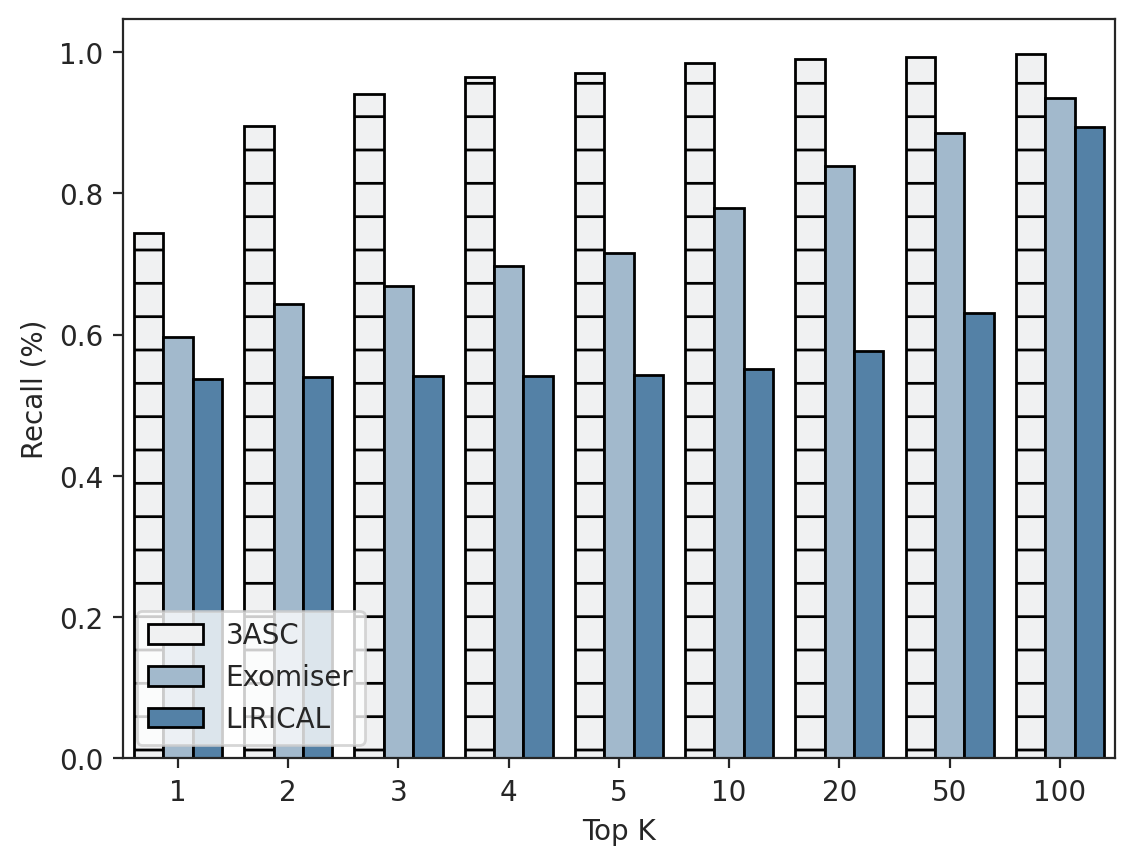

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# sns.set_context('paper')
# sns.set_color_codes('pastel')
sns.set_style("ticks")
figure_data = pd.DataFrame(
    {
        "topk": exomiser_topk.tolist() + asc3_topk.tolist() + lirical_topk.tolist(),
        "Tool": ["Exomiser"] * len(exomiser_topk) + ["3ASC"] * len(asc3_topk) + ["LIRICAL"] * len(lirical_topk),
        "rank": ks * 3,
    }
)

sns.color_palette("Paired")
legend_order = ["3ASC", "Exomiser", "LIRICAL"]
fig, axes = plt.subplots(dpi=200)
bar = sns.barplot(
    figure_data, 
    x="rank", 
    y="topk", 
    hue="Tool", 
    hue_order=legend_order,
    color="steelblue", 
    edgecolor="k", 
    ax=axes,
)

axes.set(xlabel="Top K", ylabel="Recall (%)")


# Loop over the bars
hatches = ['-', '+', 'x', '\\', '*', 'o']
for i, thisbar in enumerate(bar.patches, start=1):
    # Set a different hatch for each bar
    if i <= len(ks):
        thisbar.set_hatch("-")

    if i > len(ks):
        continue
        # thisbar.set_hatch("//")
    if i > len(ks)*2:
        continue

plt.legend(loc="lower left")
plt.savefig("figure3_benchmark.png")

Gene level

In [ ]:
import tqdm
from a4c.utils.parse_exomiser_files import ExomiserOutputParser
from a4c.utils.parse_lirical_files import LiricalOutputParser

exomiser_dir = "/data2/heon_dev/repository/3ASC-Confirmed-variant-Resys/notebooks/MIL/exomiser"

exomiser_dfs = dict()
exomiser = ExomiserOutputParser(exomiser_dir, mode="genes")
for sample_id in tqdm.tqdm(os.listdir(exomiser_dir)):
    try:
        exomiser_dfs[sample_id] = exomiser.parse(sample_id)
    except:
        continue

lirical_dir = exomiser_dir.replace("exomiser", "lirical")
lirical_dfs = dict()
lirical = LiricalOutputParser(lirical_dir, mode="genes")
for sample_id in tqdm.tqdm(os.listdir(lirical_dir)):
    try:
        lirical_dfs[sample_id] = lirical.parse(sample_id)
    except:
        continue

In [ ]:
import tqdm
def get_all_cpra2symbol(sample_ids:set):
    dir = "/data/shared/EVIDENCE.tucuxi.result/result"

    res = dict()
    for sample_id in tqdm.tqdm(os.listdir(dir)):
        if sample_id not in sample_ids:
            continue

        path = os.path.join(dir, sample_id, f"{sample_id}.uploaded_data.tsv.gz")
        if not os.path.exists(path):
            continue

        try:
            data = pd.read_csv(path, sep="\t", compression="gzip")
        except:
            data = pd.read_csv(path, sep="\t", compression="gzip", skiprows=2)

        subset = data.set_index("#Uploaded_variation")["SYMBOL"].to_dict()
        res.update(subset)
    
    return res


cpra2gene = get_all_cpra2symbol(lirical_dfs.keys() | exomiser_dfs.keys())


In [ ]:
def benchmark_tool_topk(df, casual_genes:list, k:int) -> bool:
    _df = df.sort_values("score", ascending=False).reset_index(drop=True).copy()

    if _df["symbol"].isin(casual_genes).sum() == 0:
        return False
    
    max_score = _df.loc[_df["symbol"].isin(casual_genes)]["score"].max()
    pred_topk = len(_df.loc[_df["score"] > max_score])

    if pred_topk > k:
        return False
    
    return True